### Author: Mohsen Ghazel (mghazel)
* **Date: March 26th, 2021**

## Project: Human brain MRI imaging segmentation using SimpleITK:
*   The objective of this project is to demonstrate how to perform semi-automated 
    segmentation of multi-modal MRI brain images using SimpleITK.
* In particular, the following two types of segmentation:
    * Uni-modal segmentation of two different modality images (T1 and T1), independently. 
    * Multi-model segmentation by combing the T1 and T2 images to achieve more accurate segmentation.
* The applied segmentation algorithms are semi-automated in they sense:
    * The user provides an initial set of seed points of the region of the interest
    * A region-growing algorithm is then applied in order to segment the image based on the provided seeds.
* We shall demonstrate the various steps involved in this task as we develop the code.

### Step 1: Imports and global variables

In [38]:
#------------------------------------------------------
# Python imports and environment setup
#------------------------------------------------------
# I/O os
import os
# Opencv
import cv2
# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# date-time to show date and time
import datetime

#------------------------------------------------------
# SimpleITK library
#------------------------------------------------------
# for installation run one of the the following 
# commands:
#------------------------------------------------------
# >> conda install -c simpleitk simpleitk
# >> pip install SimpleITK
#------------------------------------------------------
import SimpleITK

# set: %matplotlib inline so that matplotlib graphs 
# will be included in your notebook, next to the code
%matplotlib inline

# Testing the OpenCV version
print("OpenCV : ",cv2.__version__)

# Testinng the numpy version
print("Numpy : ",np.__version__)

# Testinng the SimpleITK version
print("SimpleITK : ",SimpleITK.__version__)

OpenCV :  3.4.8
Numpy :  1.19.2
SimpleITK :  2.0.2


### Step 2: Helper functions
* These are helper functions used for processing and visualizing the data

In [39]:
"""Display 2D SimpleITK image with a grayscale colormap and accompanying axes

    Parameters:
    img (int): input image
    title (string): figure title
    margin (int): figure margin
    dpi (int): figure dpi resolution

    Returns:
    None
   """
def itk_visualize(img, title=None, margin=0.0, dpi=40):
    nda = SimpleITK.GetArrayFromImage(img)
    #spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    #extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    extent = (0, nda.shape[1], nda.shape[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    # display is gray color-map
    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    # add the figure titke if provided
    if title:
        plt.title(title)
    # show figure
    plt.show()

In [40]:
"""Tile multiple images together into a vector:

    Parameters:
    lstImgs (lstImgs): list input image
    
    Returns:
    None
   """
def itk_tile_images_vector(lstImgs):
    lstImgToCompose = []
    for idxComp in range(lstImgs[0].GetNumberOfComponentsPerPixel()):
        lstImgToTile = []
        for img in lstImgs:
            lstImgToTile.append(SimpleITK.VectorIndexSelectionCast(img, idxComp))
        lstImgToCompose.append(SimpleITK.Tile(lstImgToTile, (len(lstImgs), 1, 0)))
    itk_visualize(SimpleITK.Compose(lstImgToCompose), "Uni-model Gray-Matter Segmentation")

### Step 3: Data

We make use of the following data set:
* Source: Retrospective Image Registration Evaluation Project
    * The RIRE Project provides patient datasets acquired with different imaging modalities, e.g., MR, CT, PET
    * These data sets are widely used in evaluation of different image registration and segmentation techniques.
* Link: https://www.insight-journal.org/rire/download_data.php
* Used test data: 
    * Patient: 101
    * Modalities: T1 and T2

In [41]:
#------------------------------------------------------
# Paths to the .mhd T1 and T2 test images files
#------------------------------------------------------
# T1-image file
filenameT1 = "./resources/RIRE/patient_101/mr_T1/patient_101_mr_T1.mhd"
# T2-image file
filenameT2 = "./resources/RIRE/patient_101/mr_T2/patient_101_mr_T2.mhd"

#### 3.1) Specify the used slice:
* The T1 and T2 modalities are 3D data sets:
    * We shall use a particular slice in order to extract 2D images
    * We elected to use slice # 25, but one may choose any other valid slice index

In [42]:
# Slice index to visualize with the itk_visualize helper function
idxSlice = 25

#### 3.2) Class of interest
* As mentioned earlier, we aim to segment the brain MRI T1 and T2 slice images:
    * The brain is mainly composed of two components:
        * Gray matter
        * White matter
    * We need to assign integer-labels to these two classes.
        * These need to be different integers but their values themselves are not important
            * We assign: labelGrayMatter = 1
            * We assign: labelWhiteMatter = 2

In [43]:
#------------------------------------------------------
# Assign an integer label to assign to the gray matter
#------------------------------------------------------
labelGrayMatter = 1
#------------------------------------------------------
# Assign an integer label to assign to the white matter
#------------------------------------------------------
labelGrayMatter = 2

### Step 4: Region-growing seeds:
* The applied segmentation algorithms are semi-automated in they sense:
    * The user provides an initial set of seed points of the region of the interest
    * A region-growing algorithm is then applied in order to segment the image based on the provided seeds.
* Thus, we need to provide a small set of initial seeds belonging to the class of interest (Gray-Matter) 
    * These points are selected from the T2 slice image
    * These seeds are specific to the input T2 slice image

In [44]:
#------------------------------------------------------
# Specify the region growing seed points for the input 
# image
#------------------------------------------------------
# Patient: 101
# Slide: 25
# Modality: T2
#------------------------------------------------------
# array of seeds 
lstSeeds = [(185, 130, idxSlice),
            (110, 165, idxSlice),
            (165, 175, idxSlice),
            (145, 50, idxSlice),
            (125, 115, idxSlice)]

## Step 5: Read and visualize the data:
* Read and visualize the selected slice number from the T1 and T2 data modalities

In [45]:
#------------------------------------------------------
# Paths to the input data .mhd files
#------------------------------------------------------
# T1 data file
filenameT1 = "./resources/RIRE/patient_101/mr_T1/patient_101_mr_T1.mhd"
# T2 data file
filenameT2 = "./resources/RIRE/patient_101/mr_T2/patient_101_mr_T2.mhd"

In [46]:
#------------------------------------------------------
# read the data
#------------------------------------------------------
# T1 data
imgT1Original = SimpleITK.ReadImage(filenameT1)
# T2 data
imgT2Original = SimpleITK.ReadImage(filenameT2)

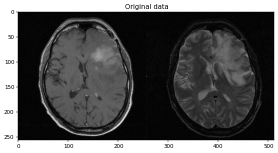

In [47]:
# visualize the T1 and T2 slices side by side (idxSlice = 25)
itk_visualize(SimpleITK.Tile(imgT1Original[:, :, idxSlice],
                         imgT2Original[:, :, idxSlice],
                         (2, 1, 0)), "Original data")

## Step 6: Image pre-processing
* As we can see from the above figure, the original image data exhibits quite a bit of noise which is very typical of MRI datasets. 
* However, since we will be applying region-growing and thresholding segmentation algorithms we need a smoother, more homogeneous pixel distribution. 
* Thus, before we start the segmentation, we need smoothen the images in order to reduce the noise side-effects on the segmentation results.

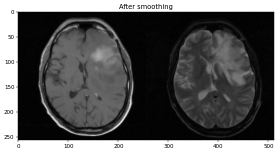

In [48]:
#------------------------------------------------------
# Apply smoothing on the T1 modality slide image
#------------------------------------------------------
imgT1Smooth = SimpleITK.CurvatureFlow(image1=imgT1Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)

#------------------------------------------------------
# Apply smoothing on the T2 modality slide image
#------------------------------------------------------
imgT2Smooth = SimpleITK.CurvatureFlow(image1=imgT2Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)

#-----------------------------------------------
#------------------------------------------------------
itk_visualize(SimpleITK.Tile(imgT1Smooth[:, :, idxSlice], 
                         imgT2Smooth[:, :, idxSlice], 
                         (2, 1, 0)), "After smoothing")

## Step 7: Initial seeds visualization
* Overlay the selected initial gray-matter seeds on the smoothed T2 slice image.

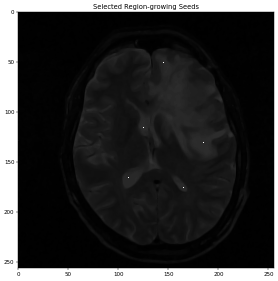

In [54]:
#------------------------------------------------------
# Loop through the seeds defined in lstSeeds and set those 
# pixels to a high value so they will stand out and allow 
# us to see them through itk_visualize. 
#------------------------------------------------------
imgSeeds = SimpleITK.Image(imgT2Smooth)

for s in lstSeeds:
    imgSeeds[s] = 10000

itk_visualize(imgSeeds[:, :, idxSlice], "Selected Region-growing Seeds")

### Step 8: Uni-Modal Segmentation
* First, starting from the selected intial seed points, we apply the region-growing algorithm to each of the two images, separately:
    * The smoothed T1-slice image imgT1Smooth
    * The smoothed T2-slice image imgT2Smooth 
* This perform uni-model image segmentation as the 2 images are segmented independently.

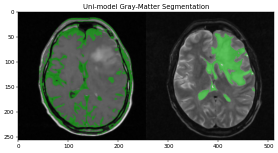

In [55]:
#------------------------------------------------------
# Starting from the selected initial seed points, 
# we apply the region-growing # on the smoothed 
# T1-slice image imgT1Smooth
#------------------------------------------------------
imgGrayMatterT1 = SimpleITK.ConfidenceConnected(image1=imgT1Smooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=7,
                                                multiplier=1.0,
                                                replaceValue=labelGrayMatter)
#------------------------------------------------------
# Starting from the selected intial seed points, 
# we apply the region-growing on the smoothed 
# T2-slice image imgT2Smooth
#------------------------------------------------------
imgGrayMatterT2 = SimpleITK.ConfidenceConnected(image1=imgT2Smooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=7,
                                                multiplier=1.5,
                                                replaceValue=labelGrayMatter)
#------------------------------------------------------
# create a rescaled integer version of imgT1Smooth 
# named imgT1SmoothInt:
# - Needed in order to create label overlays
#------------------------------------------------------
imgT1SmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgT1Smooth), 
                                imgGrayMatterT1.GetPixelID())
#------------------------------------------------------
# create a rescaled integer version of imgT2Smooth 
# named imgT2SmoothInt:
#------------------------------------------------------
# - Needed in order to create label overlays
#------------------------------------------------------
imgT2SmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgT2Smooth), 
                                imgGrayMatterT2.GetPixelID())

# visualize the uni-model segmentation results for the 2 images
itk_tile_images_vector([SimpleITK.LabelOverlay(imgT1SmoothInt[:,:,idxSlice], 
                                      imgGrayMatterT1[:,:,idxSlice]),
               SimpleITK.LabelOverlay(imgT2SmoothInt[:,:,idxSlice], 
                                     imgGrayMatterT2[:,:,idxSlice])])

### Step 9: Perform multi-modal segmentation

* Multi-modal segmentation gives us multiple views of the same anatomies: 
    * In our case by combining the T1 and T2 images we get two significantly different views of the gray matter and areas that were not connected in one of the images may be connected in the other. 
    * In addition, specious connections appearing in one image due to excessive noise or artifacts will most likely not appear in the other.

    * This allows us to perform the segmentation having more information in our arsenal and achieving the same or better results with more stringent criteria and far fewer iterations.


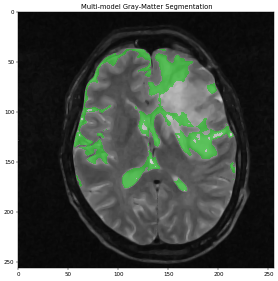

In [56]:
#------------------------------------------------------
# Firstly, we begin by ‘combining’ the two images: 
#  - In order to do that we simply use the ComposeImageFilter 
#  - The result of the composition is the imgComp image.
#------------------------------------------------------
imgComp = SimpleITK.Compose(imgT1Smooth, imgT2Smooth)

#------------------------------------------------------
# Perorm the segmentation, using the VectorConfidenceConnectedImageFilter 
# class instead of the ConfidenceConnectedImageFilter, 
# used for the uni-modal segmentation
#------------------------------------------------------
imgGrayMatterComp = SimpleITK.VectorConfidenceConnected(image1=imgComp, 
                                               seedList=lstSeeds,
                                               numberOfIterations=1,
                                               multiplier=0.1,
                                               replaceValue=labelGrayMatter)
#------------------------------------------------------
# display the multi-model image segmentation results
#------------------------------------------------------
itk_visualize(SimpleITK.LabelOverlay(imgT2SmoothInt[:,:,idxSlice], 
                                 imgGrayMatterComp[:,:,idxSlice]), "Multi-model Gray-Matter Segmentation")

### Step 10: Save the multi-model segmentation MHD output

In [57]:
#------------------------------------------------------
# save the final multi-model segmentation MHD output 
# imgGrayMatterCom
#------------------------------------------------------
SimpleITK.WriteImage(imgGrayMatterComp, "GrayMatter.mhd")

In [58]:
#------------------------------------------------------
# display a final message
#------------------------------------------------------
# current time
now = datetime.datetime.now()
# display a message
print('Program executed successfully on: '+ str(now.strftime("%Y-%m-%d %H:%M:%S") + "...Goodbye!\n"))

Program executed successfully on: 2021-03-28 10:27:14...Goodbye!

